[Reference: Novel indexes for diagnosing metabolic syndrome in apparently healthy Gujarati Asian Indians: a cross-sectional study](https://academic.oup.com/qjmed/article/109/11/717/2631720?login=false)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
def compute_z_score(x, params):
    return (x-params[0])/params[1]

### Have taken care of cases when data can go below -3 and above +3

In [3]:
def compute_percentiles(func, params, patient_details, plabel='Healthy Population', nlabel='Diseased Population', visualise=True):
    
    score = func(patient_details)
    sex = patient_details['sex']
    print(f'{func.__name__} Score: {round(score,2)}')
    percentiles = [norm.cdf(score, params[sex][x][0], params[sex][x][1])*100 for x in ['MetSN', 'MetSP']]
    print(f'Healthy: {round(percentiles[0], 2)}th, Diseased: {round(percentiles[1], 2)}th')
    
    if(visualise):
        metsn_params = params[sex]['MetSN']
        metsp_params = params[sex]['MetSP']
                
        plt.figure(figsize=(14,5))
        
        z_score = compute_z_score(score, metsn_params)
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-r, r, r*100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,1)
        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(plabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        z_score = compute_z_score(score, metsp_params)
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-r, r, r*100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,2)
        plt.plot(x1, y1, color='red')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(nlabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        
        plt.show()
        
    return percentiles

# LAP

#### Formulae

Males: (WC (cm) - 65) × (TG (mmol/l))

Females: (WC (cm) - 58) × (TG (mmol/l))

In [4]:
LAP_params = {
                    'M': {'MetSN': [26.371, 17.52], 'MetSP': [57.77, 31.84]},
                    'F': {'MetSN': [25.62, 16.23], 'MetSP': [55.51, 30.94]}
            }

In [5]:
# wc(cm), TG(mg/dl)
def LAP(patient):
    sex, wc, TG = patient['sex'], patient['WC'], patient['TG']
    if (sex == 'M'):
        return (wc-65) * (TG/88.57)
    elif (sex == 'F'):
        return (wc-58) * (TG/88.57)

# VAI

### Formulae

**Males:** VAI=(WC/(39.69+(1.88×BMI)))×(TG/0.03)×(1.31/HDL)

**Females:** VAI(WC/(36.58+(1.89×BMI)))×(TG/0.81)×(1.52/HDL)

In [6]:
VAI_params = {
                    'M': {'MetSN': [65.435, 50.72], 'MetSP': [138.00, 120.43]},
                    'F': {'MetSN': [66.58, 34.20], 'MetSP': [141.28,76.22]}
            }

In [7]:
# WC(cm), BMI(kg/m2), TG(mmol/L), HDL(mmol/L)
def VAI(patient):
    sex, WC, BMI, TG, HDL = patient['sex'], patient['WC'], patient['BMI'], patient['TG'], patient['HDL']
    if (sex == 'M'):
        return (WC/(39.69+(1.88*BMI)))*(TG/0.03)*(1.31/HDL)
    elif (sex == 'F'):
        return (WC/(36.58+(1.89*BMI)))*(TG/0.81)*(1.52/HDL)

# Diabetes Score 1

In [8]:
Diabetes1_params = {
                    'M': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]},
                    'F': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]}
            }

In [9]:
def compute_age_factor_A(BMI, age):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return -0.0002409*(age**3) +0.035989*(age**2)-1.2938*age +15.9448
    elif(BMI>=36): return -0.00018165*(age**3) +0.026829*(age**2)-0.88434*age +9.7043
    elif(BMI>=34): return -9.02e-05*(age**3) +0.014945*(age**2)-0.44345*age +4.9542
    elif(BMI>=32): return -0.00015453*(age**3) +0.024283*(age**2)-0.89484*age +10.4953
    elif(BMI>=30): return -0.00014778*(age**3) +0.023199*(age**2)-0.88224*age +10.346
    elif(BMI>=28): return -0.0001085*(age**3) +0.017384*(age**2)-0.6534*age +7.1327
    elif(BMI>=26): return -6.576e-05*(age**3) +0.011355*(age**2)-0.44233*age +5.225
    elif(BMI>=24): return -3.9578e-05*(age**3) +0.0075099*(age**2)-0.31027*age +3.7777
    elif(BMI>=22): return -1.5022e-05*(age**3) +0.0038618*(age**2)-0.16786*age +2.0549
    elif(BMI>=20): return 0.0016166*(age**2)-0.089607*age +1.2032
    elif(BMI>=18.5): return 0.00093971*(age**2)-0.042102*age +0.57713

In [10]:
def Diabetes1(patient):
    sex, age, glu, TG, BMI = patient['sex'], patient['age'], patient['glu'], patient['TG'], patient['BMI']
    age_factor = compute_age_factor_A(BMI, age)
    return (math.log((1+((glu/80)*(TG/80)*(BMI/22)))*(1+(age_factor/100))))*25

# Diabetes Score 2

In [11]:
Diabetes2_params = {
                    'M': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]},
                    'F': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]}
            }

In [12]:
def compute_age_factor_B(BMI):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return 19.74
    elif(BMI>=36): return 17.75
    elif(BMI>=34): return 20.28
    elif(BMI>=32): return 15.21
    elif(BMI>=30): return 12.58
    elif(BMI>=28): return 10.62
    elif(BMI>=26): return 9.44
    elif(BMI>=24): return 7.75
    elif(BMI>=22): return 7.11
    elif(BMI>=20): return 6.02
    elif(BMI>=18.5): return 4.27

In [32]:
def Diabetes2(patient):
    sex, age, glu, TG, BMI = patient['sex'],patient['age'],patient['glu'],patient['TG'],patient['BMI']
    age_factor_A = compute_age_factor_A(BMI, age)
    age_factor_B = compute_age_factor_B(BMI)
    age_factor = (age_factor_A/age_factor_B)/10
    return 6.6667*((math.log(glu*TG/2))*(1+BMI/40)*(1+age_factor))-66.667

# NAFLD

In [14]:
NAFLD_params = {
                    'M': {'MetSN': [20.47, 8.76], 'MetSP': [55.21, 16.04]},
                    'F': {'MetSN': [20.47, 8.76], 'MetSP': [55.21, 16.04]}
            }

In [36]:
def TG_factor_score(TG):
    if(TG>400): return 3
    elif(TG>50): return 0.0085714*TG-0.42857
    else: return 0

def HOMA_IR_factor_score(HOMA_IR):
    if(HOMA_IR>6): return 3
    elif(HOMA_IR>0.5): return 0.54545*HOMA_IR-0.27273
    else: return 0

def GGT_factor_score(GGT):
    if(GGT>60): return 3
    elif(GGT>20): return 0.075*GGT-1.5
    else: return 0

def ALT_AST_factor_score(ALT_AST):
    if(ALT_AST>1.5): return 3
    elif(ALT_AST>0.95): return 5.4545*ALT_AST-5.1818
    else: return 0

def Uric_acid_factor_score(Uric_acid):
    if(Uric_acid>450): return 3
    elif(Uric_acid>250): return 0.015*Uric_acid-3.75
    else: return 0

In [16]:
def compute_nafld_factor_scores(patient_details):
    TG, HOMA_IR, GGT, ALT_AST, Uric_acid = patient_details
    nafld_factor_scores = []
    nafld_factor_scores.append(TG_factor_score(TG))
    nafld_factor_scores.append(HOMA_IR_factor_score(HOMA_IR))
    nafld_factor_scores.append(GGT_factor_score(GGT))
    nafld_factor_scores.append(ALT_AST_factor_score(ALT_AST))
    nafld_factor_scores.append(Uric_acid_factor_score(Uric_acid))
    return nafld_factor_scores

In [17]:
def NAFLD(patient):
    NRS_TG, NRS_HOMA_IR, NRS_GGT, NRS_ALT_AST, NRS_Uric_acid = compute_nafld_factor_scores([patient['TG'], patient['HOMA_IR'], patient['GGT'], patient['ALT']/patient['AST'], patient['Uric_acid']])
    return (NRS_TG + NRS_HOMA_IR + 2*NRS_GGT + 2*NRS_ALT_AST + NRS_Uric_acid)*(100/21)

# Cardiac Risk Score

In [18]:
Cardiac_params = {
    'M': {'MetSN': [32.85, 14.35], 'MetSP': [55.66, 17.92]},
    'F': {'MetSN': [32.85, 14.35], 'MetSP': [55.66, 17.92]}
}

In [19]:
def TG_HDL_factor_score(TG, HDL):
    TG_HDL = TG/HDL
    if(TG_HDL>10): return 3
    elif(TG_HDL>0.9):return 0.3297*(TG_HDL) - 0.2967
    else: return 0

def TC_HDL_factor_score(TC, HDL):
    TC_HDL = TC/HDL
    if(TC_HDL>8): return 3
    elif(TC_HDL>1.5): return 0.4615*(TC_HDL)-0.6923
    else: return 0

def LDL_HDL_factor_score(LDL, HDL):
    LDL_HDL = LDL/HDL
    if(LDL_HDL>6): return 3
    if(LDL_HDL>0.9): return 0.5882*(LDL_HDL) - 0.5294
    else: return 0

In [20]:
def compute_cardiac_factor_scores(patient_details):
    TG, TC, LDL, HDL = patient_details
    cardiac_factor_scores = []
    cardiac_factor_scores.append(TG_HDL_factor_score(TG,HDL))
    cardiac_factor_scores.append(TC_HDL_factor_score(TC, HDL))
    cardiac_factor_scores.append(LDL_HDL_factor_score(LDL, HDL))
    return cardiac_factor_scores

In [55]:
def Cardiac(patient):
    CRS_TG_HDL, CRS_TC_HDL, CRS_LDL_HDL = compute_cardiac_factor_scores([patient['TG'], patient['TC'], patient['LDL'], patient['HDL']])
    return (math.log(CRS_TG_HDL + CRS_TC_HDL + CRS_LDL_HDL))*(100/2.3)

# Dyslipidimia

In [71]:
def Dyslipidimia(patient, visualise = True):
    TG, TC, HDL, LDL = patient['TG'],patient['TC'],patient['HDL'],patient['LDL']
    score = min((math.log10(1+((TG/80)*(TC/150)*(LDL/80)*(50/HDL))))*(100/3), 100)
    if(visualise):
        z_score = compute_z_score(score, [1.14,0.54])
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-r, r, r*100)
        y1 = norm.pdf(x1, 0,1)

        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(f"Dyslipidimia Score Distribution")
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        plt.show()
    return score

# Hypertension Score

In [41]:
def age_gender_effect(sex, age):
    if(sex == 'M'): return 1+0.25*((0.7304*age+3.6894)/100)
    else: return 1+0.25*((0.9452*age-12.971)/100)
    
def uric_acid_effect(sex, Uric_acid):
    if(sex == 'M' or (sex == 'F' and Uric_acid <= 339)): return 1
    else: return 1+0.5*((0.0541*Uric_acid - 10.811)/100)

In [42]:
def Hypertension(patient):
    sex, age, Uric_acid, SBP, DBP = patient['sex'], patient['age'], patient['Uric_acid'], patient['SBP'], patient['DBP']
    MAP = (SBP+2*DBP)/3
    Anthro_effect = age_gender_effect(sex, age)*uric_acid_effect(sex, Uric_acid)
    
    return 90.909*((MAP/73)*Anthro_effect -1)

In [24]:
def obtain_SBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [137.2,21.4]
        elif(age>=65): return [136.5, 20.4]
        elif(age>=55): return [134.1, 19.5]
        elif(age>=45): return [130.2, 18.2]
        elif(age>=20): return [124.1, 15.1]
        elif(age>=18): return [121.4, 15]
    elif(sex == 'F'):
        if(age>=75): return [136, 22.7]
        elif(age>=65): return [136, 21.2]
        elif(age>=55): return [132.4, 19.3]
        elif(age>=45): return [126.7, 18]
        elif(age>=20): return [115.6, 15]
        elif(age>=18): return [111.4, 12.4]

In [25]:
def obtain_DBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [80.1, 12.4]
        elif(age>=65): return [81.8, 11.9]
        elif(age>=55): return [82.9, 11.6]
        elif(age>=45): return [83.2, 11.7]
        elif(age>=20): return [79.6, 10.9]
        elif(age>=18): return [78.4, 11]
    elif(sex=='F'):
        if(age>=75): return [80.6, 12.9]
        elif(age>=65): return [80.8, 11.9]
        elif(age>=55): return [81.1, 11]
        elif(age>=45): return [80.3, 10.9]
        elif(age>=20): return [75.1, 10.4]
        elif(age>=18): return [71.9, 9.6]

In [61]:
def plot_SBP_DBP_distribution(patient):
    
    sex, age, SBP, DBP = patient['sex'],patient['age'],patient['SBP'],patient['DBP']
    
    if(age>=75): age_grp = ">=75"
    elif(age>=65): age_grp = "65-74"
    elif(age>=55): age_grp = "55-64"
    elif(age>=45): age_grp = "45-54"
    elif(age>=20): age_grp = "20-44"
    elif(age>=18): age_grp = "18-19"
    
    plt.figure(figsize=(14,5))

    z_score = compute_z_score(SBP, obtain_SBP_params(sex, age))
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)

    plt.subplot(1,2,1)
    plt.plot(x1, y1, color='blue')
    plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
    plt.title(f"SBP Distribution, Age: {age_grp}, {sex}")
    plt.xlabel("Z-score")
    plt.xticks([x for x in range(-r,r+1)])
    if z_score < 0:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
    else:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
    plt.ylim(0, norm.pdf(0,0,1)*1.15)

    z_score = compute_z_score(DBP, obtain_DBP_params(sex, age))
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)

    plt.subplot(1,2,2)
    plt.plot(x1, y1, color='blue')
    plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
    plt.title(f"DBP Distribution, Age: {age_grp}, {sex}")
    plt.xlabel("Z-score")
    plt.xticks([x for x in range(-r,r+1)])
    if z_score < 0:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
    else:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
    plt.ylim(0, norm.pdf(0,0,1)*1.15)

    plt.show()

In [47]:
def compute_all_percentiles(patient):
    compute_percentiles(LAP, LAP_params, patient, plabel='Healthy Population', nlabel='Obese Population', visualise=True)
    compute_percentiles(VAI, VAI_params, patient, plabel='Healthy Population', nlabel='Metabolic Syndrome Positive Population', visualise=True)
    compute_percentiles(Diabetes1, Diabetes1_params, patient, plabel='Healthy Population', nlabel='Diabetic Population', visualise=True)
    compute_percentiles(Diabetes2, Diabetes2_params, patient, plabel='Healthy Population', nlabel='Diabetic Population', visualise=True)
    compute_percentiles(NAFLD, NAFLD_params, patient, plabel='Healthy Population', nlabel='NAFLD Population', visualise=True)
    compute_percentiles(Cardiac, Cardiac_params, patient, plabel='Healthy Population', nlabel='Unhealthy Population', visualise=True)
    print(f'Hypertension Score: {Hypertension(patient)}')
    plot_SBP_DBP_distribution(patient)
    print(f'Dyslipidimia Score: {Dyslipidimia(patient, visualise = True)}')

In [48]:
P_II_14 = {
    'sex' :'M',
    'WC' : 104,
    'TG' : 568,
    'BMI' : 30.03,
    'HDL' : 32.3,
    'age' :59,
   'glu' : 176,
    'HOMA_IR' : 9.99,
    'GGT' : 69,
    'ALT' : 14,
    'AST': 14,
    'Uric_acid': 450,
    'TC' : 281,
    'LDL' : 174,
    'SBP' : 143,
    'DBP': 85
}

LAP Score: 250.11
Healthy: 100.0th, Diseased: 100.0th


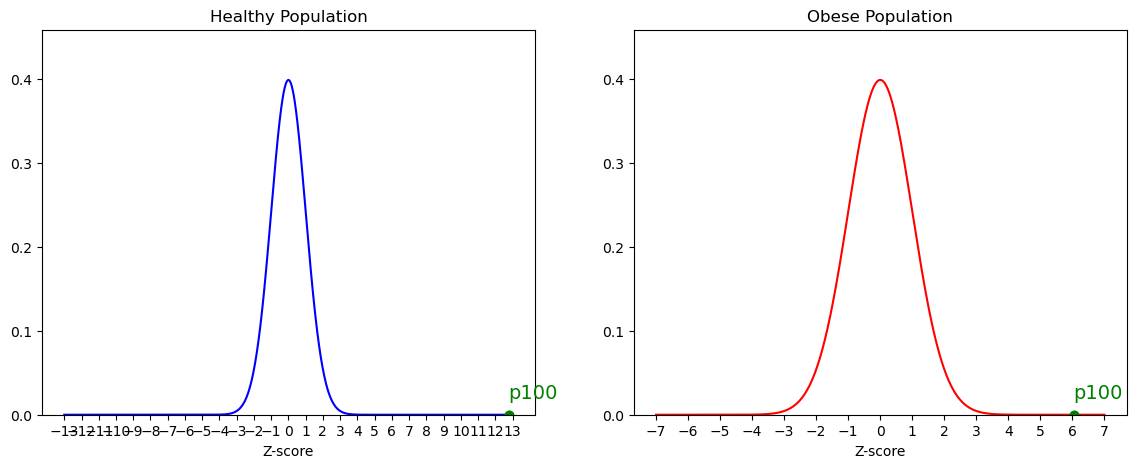

VAI Score: 830.61
Healthy: 100.0th, Diseased: 100.0th


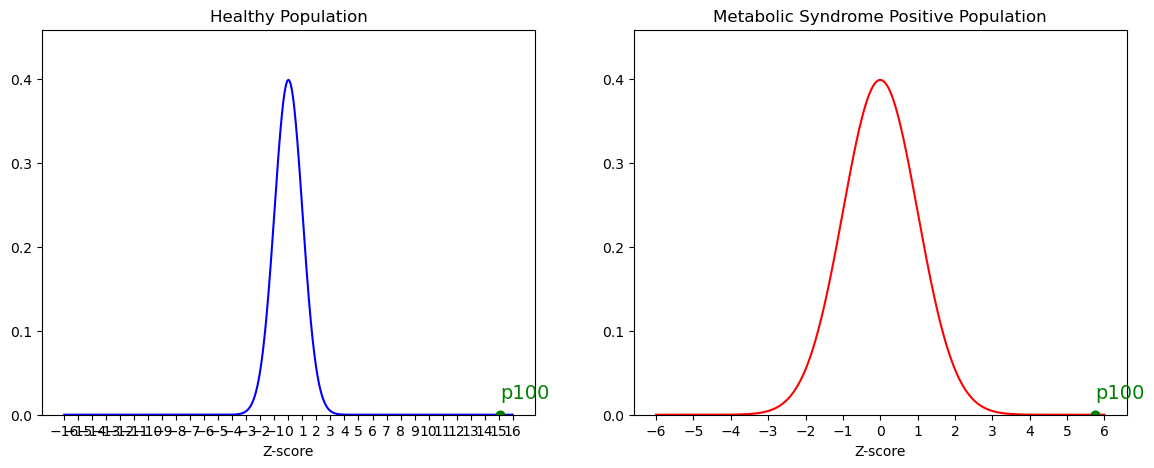

Diabetes1 Score: 79.72
Healthy: 100.0th, Diseased: 96.9th


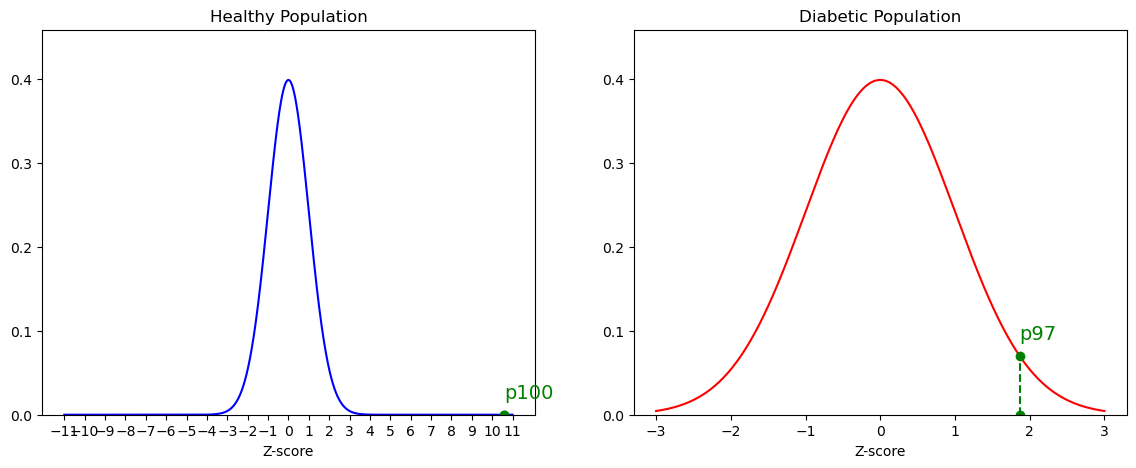

Diabetes2 Score: 68.35
Healthy: 100.0th, Diseased: 97.3th


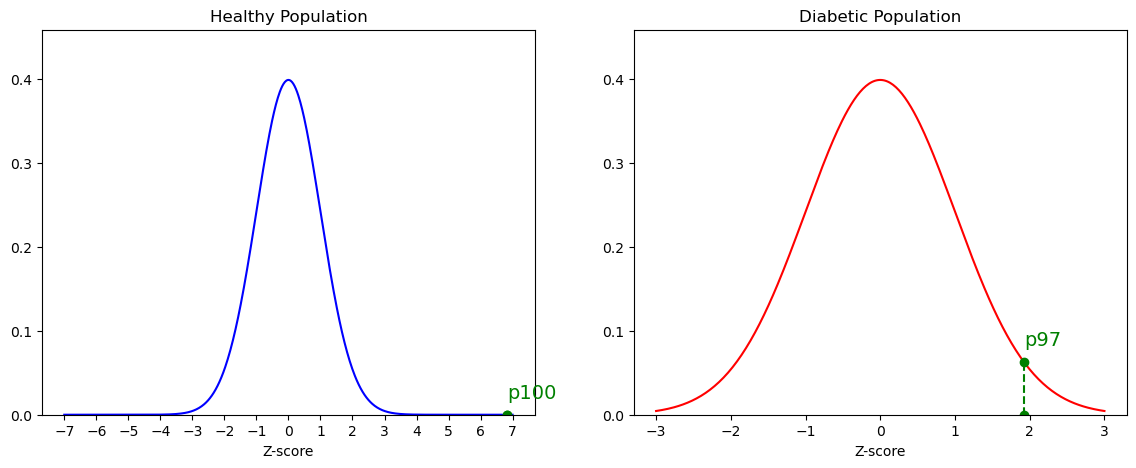

NAFLD Score: 74.03
Healthy: 100.0th, Diseased: 87.96th


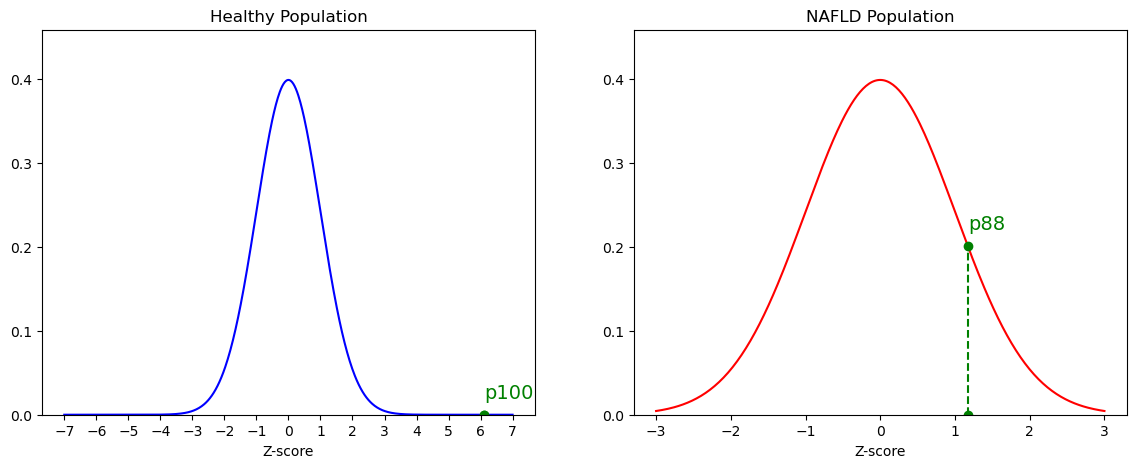

Cardiac Score: 93.75
Healthy: 100.0th, Diseased: 98.32th


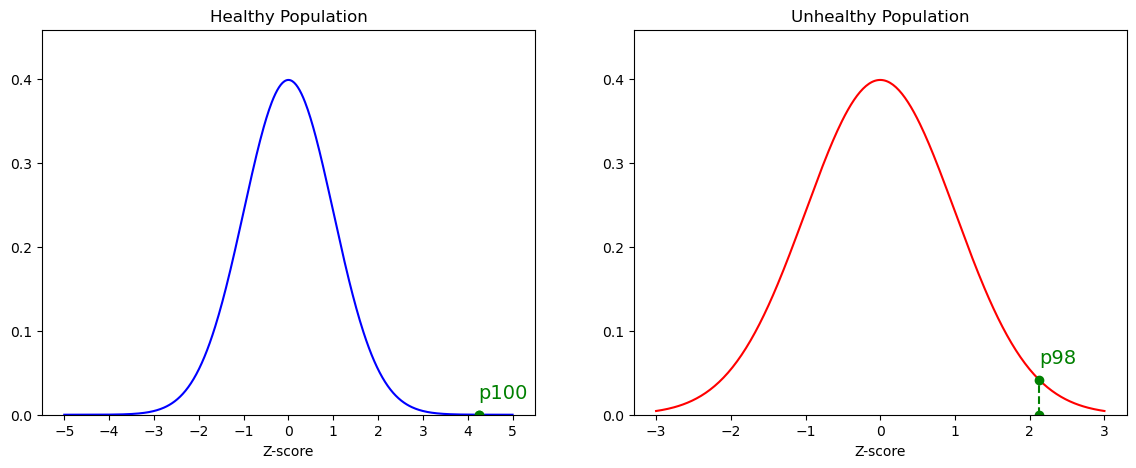

Hypertension Score: 54.21650763482876


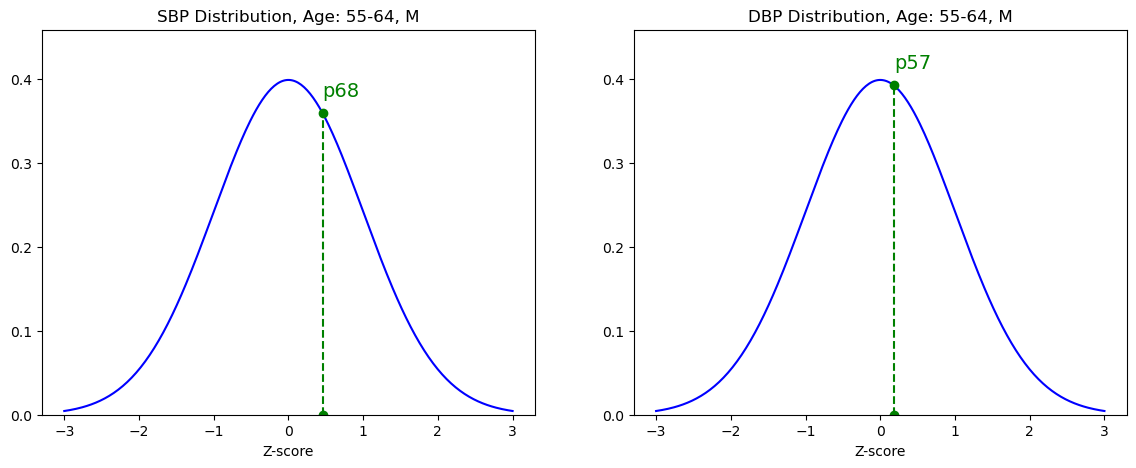

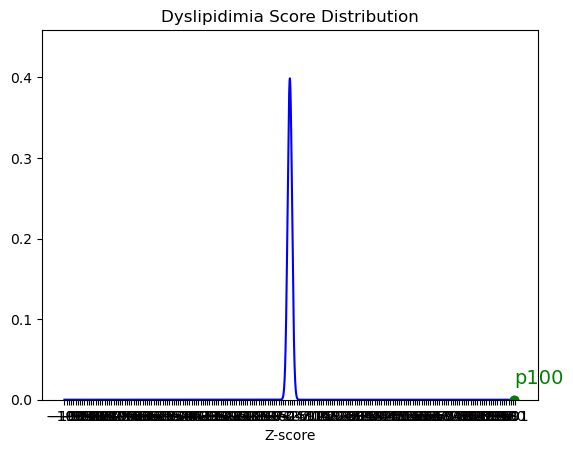

Dyslipidimia Score: 55.356383369286554


In [73]:
compute_all_percentiles(P_II_14)

In [37]:
P_I_17 = {
    'sex' :'F',
    'WC' : 78,
    'TG' : 220,
    'BMI' : 30.82,
    'HDL' : 42.8,
    'age' :49,
   'glu' : 134,
    'HOMA_IR' : 4.96,
    'GGT' : 29,
    'ALT' : 24,
    'AST': 14,
    'Uric_acid': 350,
    'TC' : 246,
    'LDL' : 186,
    'SBP' : 132,
    'DBP': 80
}

LAP Score: 49.68
Healthy: 93.09th, Diseased: 42.52th


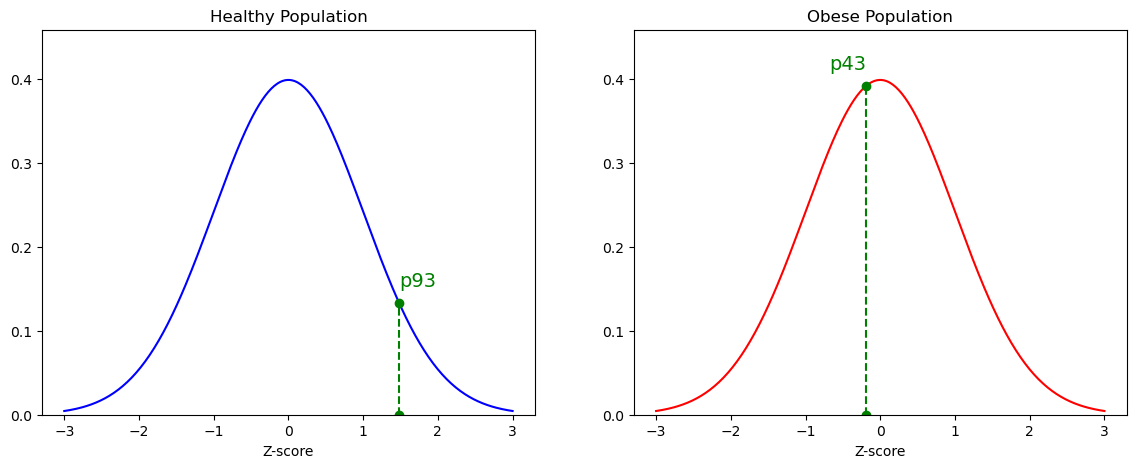

VAI Score: 7.93
Healthy: 4.32th, Diseased: 4.01th


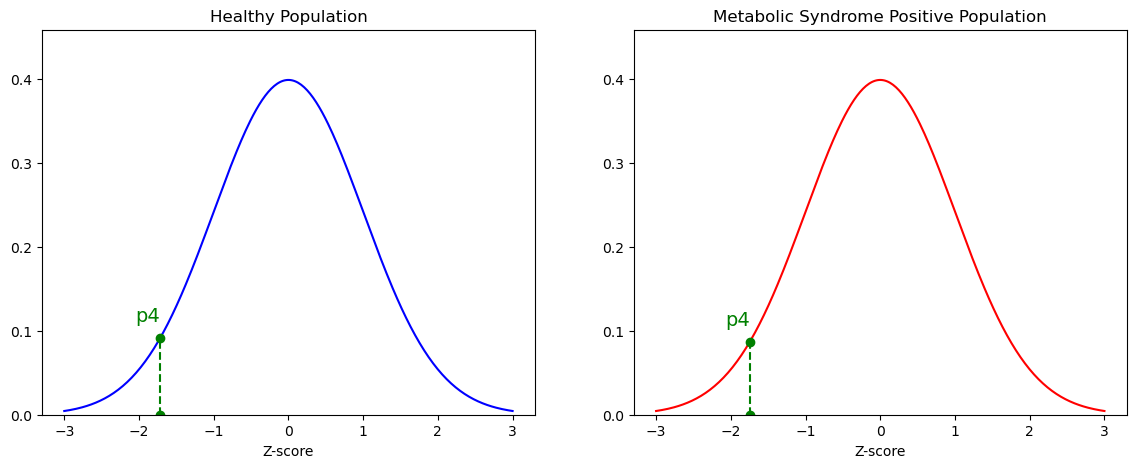

Diabetes1 Score: 51.54
Healthy: 100.0th, Diseased: 61.32th


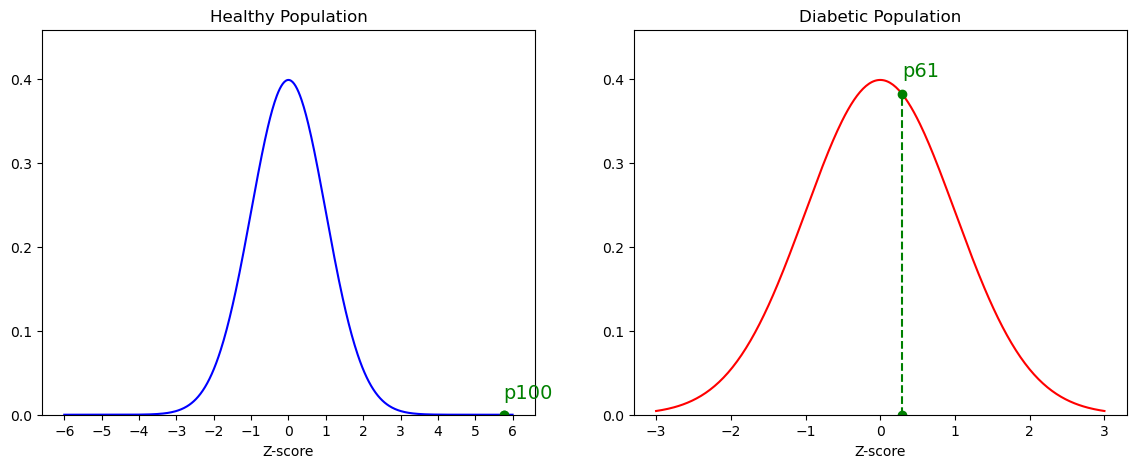

Diabetes2 Score: 51.52
Healthy: 100.0th, Diseased: 74.31th


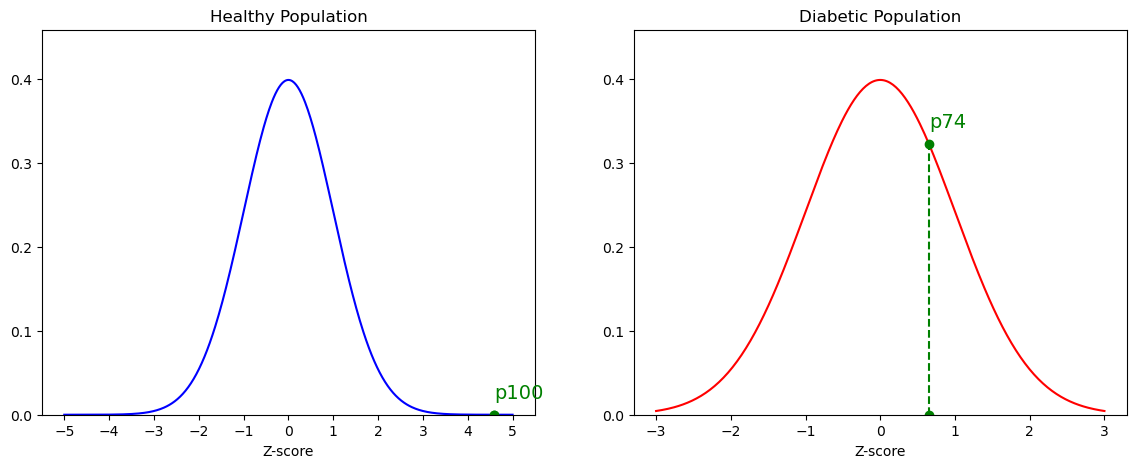

NAFLD Score: 60.67
Healthy: 100.0th, Diseased: 63.31th


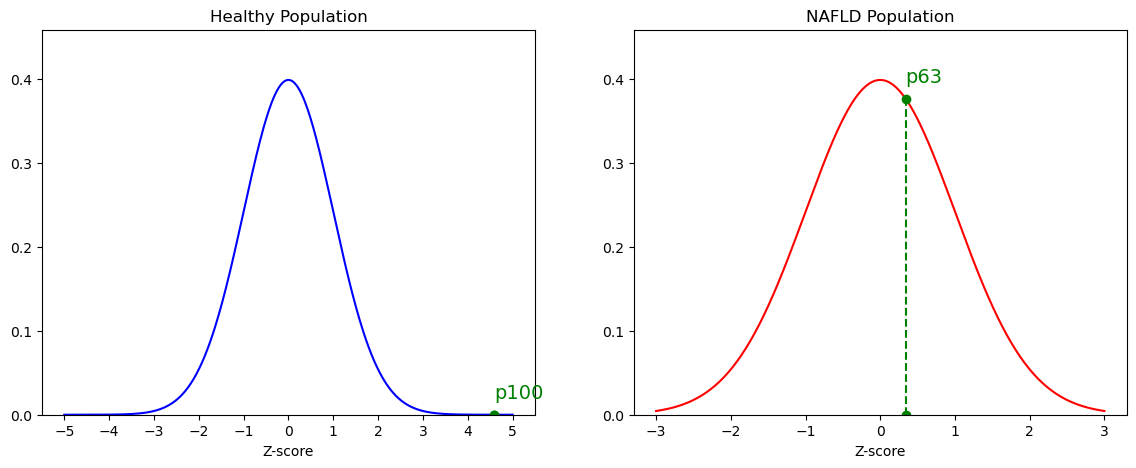

Cardiac Score: 73.2
Healthy: 99.75th, Diseased: 83.62th


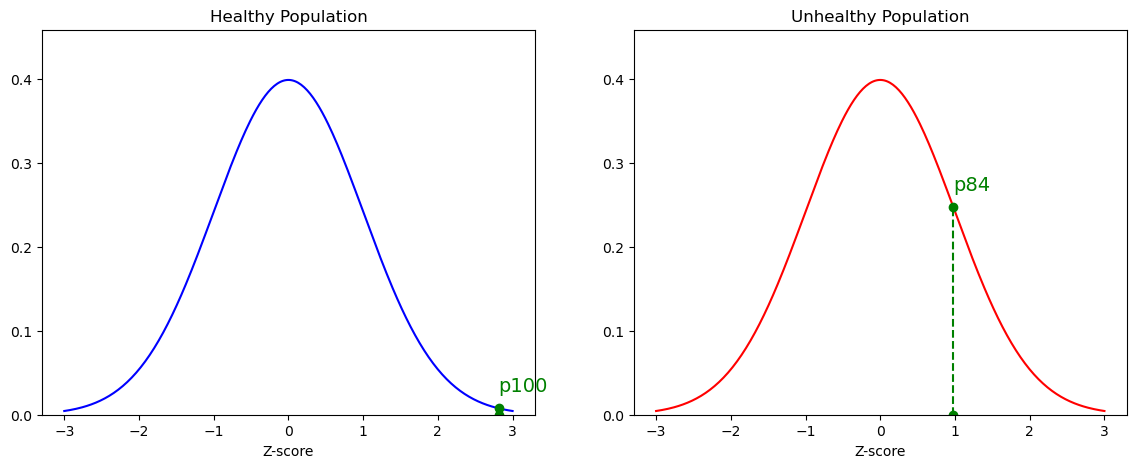

Hypertension Score: 45.7412346090227


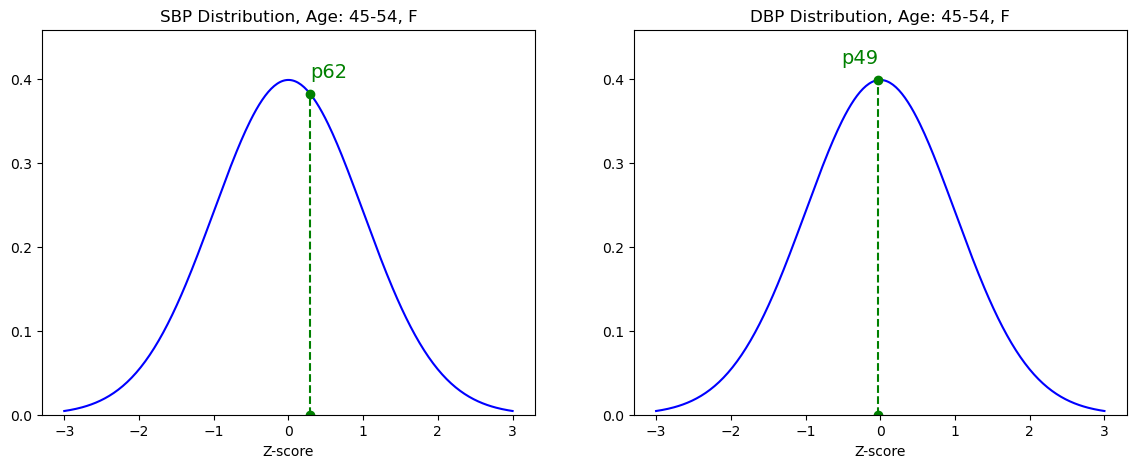

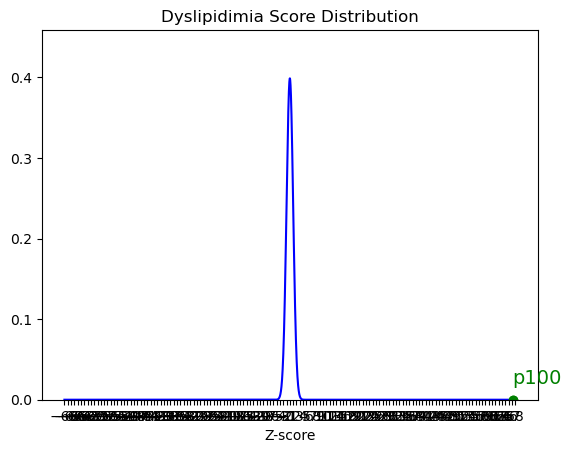

Dyslipidimia Score: 37.406876848743075


In [72]:
compute_all_percentiles(P_I_17)

### Test Check

In [ ]:
# nafld_factor_scores.append(TG_factor_score(TG))
# nafld_factor_scores.append(HOMA_IR_factor_score(HOMA_IR))
# nafld_factor_scores.append(GGT_factor_score(GGT))
# nafld_factor_scores.append(ALT_AST_factor_score(ALT_AST))
# nafld_factor_scores.append(Uric_acid_factor_score(Uric_acid))

